# Contenets:
- compute return and understand risk measurements
- compute and understand different portfolio investing strategies
- conduct factor analysis
- understand risk management strategy

# Tools:
- mean, skew, kurtosis and shapiro test
- Equal Weights Portfolio, Market cap weighted and Markowitz Portfolios (MSR and GMV)
- CAPM and FamaFrench 3 and 5 factors models
- VaR and CVaR
- Monte Carlo Simulation

# Import Package

In [1]:
from IPython.display import display, Image
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import numpy as np
import pandas as pd

plt.style.use('seaborn')
plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import shapiro
from scipy.stats import norm

import statsmodels.formula.api as smf 

# Univariate Investment Risk and Returns
- risk in financial markets is a measure of uncertainty Dispersion or variance of financial returns
- measurement: standard deviation or variance of daily returns, kurtosis or skewnessof the daily returns distribution and historical drawdown

## Financial Returns

### Returns

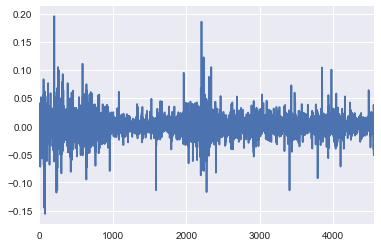

In [2]:
StockPrices = pd.read_csv('MSFTPrices.csv', parse_dates=['Date'])
StockPrices = StockPrices.sort_values(by='Date')

# Calculate the daily returns of the adjusted close price
StockPrices['Returns'] = StockPrices['Adjusted'].pct_change()

# Plot the returns column over time
StockPrices['Returns'].plot()
plt.show()

### Returns distribution

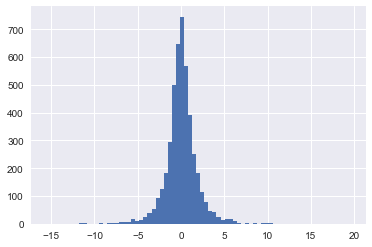

In [3]:
# Convert the decimal returns into percentage returns
percent_return = StockPrices['Returns']*100

# Drop the missing values
returns_plot = percent_return.dropna()

# Plot the returns histogram
plt.hist(returns_plot, 75)
plt.show()

## Financial Risk

### Mean, variance, and normal distribution
- normal distributions have a skewness near 0 and a kurtosis near 3
- financial returns tend to have a higher probability of both outliers and of positive returns than a noraml distribution
- a high kurtosis or high skewness is indicators of nor-normal returns

#### Mean and variance
- STD/Volatility: σ 
- Vriance: σ^2
- Average Annualized Return=$((1+μ)^{252})−1$
- Annualized Volatility=$σ*\sqrt{252}$

In [4]:
#implied annualized average return
mean_return_daily = np.mean(StockPrices['Returns'])
mean_return_annualized = ((1+mean_return_daily)**252)-1
print(f"Annual Mean of Returns: {mean_return_annualized:0.3f}%")

#implied annualized volatility
sigma_return_daily = np.std(StockPrices['Returns'])
sigma_return_annualized = sigma_return_daily*np.sqrt(252)
print(f"Volatility of Returns: {sigma_return_annualized:0.3f}%")

Annual Mean of Returns: 0.100%
Volatility of Returns: 0.307%


### Skewness and kurtosis
- testing for Normality: the null hypothesis of the Shapiro-Wilk test is that the data are normally distributed

In [5]:
returns_skewness = skew(StockPrices["Returns"].dropna())
excess_kurtosis = kurtosis(StockPrices["Returns"].dropna())

p_value = shapiro(StockPrices["Returns"].dropna())[1]
if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


# Portfolio Risk Measurement

### Sharpe ratios
- when the Sharpe ratio is below 1, the return does not outweigh the risk proportionally
- $S=(R_a−r_f)/σ_a$
- $S$: sharpe Ratio
- $R_a$: asset return
- $r_f$: risk-free rate of return
- $σ_a$: asset volatility

In [6]:
# Risk free rate
risk_free = 0

# Calculate the Sharpe Ratio
sharpe_ratio = (mean_return_daily - risk_free)/sigma_return_daily
print(f"Sharpe Ratio: {sharpe_ratio:0.3f}%")

Sharpe Ratio: 0.020%


### Sortino ratio
- the Sortino ratio is just like the Sharpe ratio, except for that it uses the standard deviation of the negative returns only, and thereby focuses more on the downside of investing

In [7]:
target = 0
# Create a downside return column with the negative returns only
downside_returns = StockPrices.loc[StockPrices['Returns'] < target]

# Calculate expected return and std dev of downside
expected_return = StockPrices['Returns'].mean()
down_stdev = downside_returns['Returns'].std()

# Calculate the sortino ratio
sortino_ratio = (expected_return - risk_free)/down_stdev
print(f"Sortino Ratio: {sortino_ratio:0.3f}%")

Sortino Ratio: 0.026%


### Maximum draw-down
- the worst performance of stock

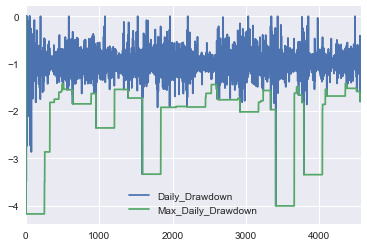

In [8]:
# Calculate the maximum value of returns using rolling().max()
roll_max = StockPrices['Returns'].rolling(min_periods=1,window=252).max()

# Calculate daily draw-down from rolling max
daily_drawdown = StockPrices['Returns']/roll_max - 1.0

# Calculate maximum daily draw-down
max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=252).min()

# Plot the results
daily_drawdown.plot(label='Daily_Drawdown')
max_daily_drawdown.plot(label='Max_Daily_Drawdown')
plt.legend()
plt.show()

# Portfolio Investing
- $R_p = R_{a1}w_{a1} + R_{a2}w_{a2}+...+R_{an}w_{an}$
- $R_p$: portfolio return
- $R_{a1}$: return for asset n
- $w_{a1}$: weight for assent n

## Portfolios Strategy

### Equal Weighted Portfolios

In [9]:
StockReturns = pd.read_csv('Big9Returns2017.csv')
StockReturns.set_index(['Date'],inplace=True)

In [10]:
# How many stocks are in your portfolio?
numstocks = 9

# Create an array of equal weights across all assets
portfolio_weights_ew = np.repeat(1/9, numstocks)

# Calculate the equally-weighted portfolio returns
StockReturns['Portfolio_EW'] = StockReturns.iloc[:, 0:numstocks].mul(portfolio_weights_ew, axis=1).sum(axis=1)

### Market-cap Weighted Portfolios
- $w_{mcap_n} = mcap_n / \sum_{i=1}^{n}{mcap_n}$

In [11]:
# Create an array of market capitalizations (in billions)
market_capitalizations = np.array([601.51, 469.25, 349.5, 310.48, 299.77, 356.94, 268.88, 331.57, 246.09])

# Calculate the market cap weights
mcap_weights = market_capitalizations/sum(market_capitalizations)

# Calculate the market cap weighted portfolio returns
StockReturns['Portfolio_MCap'] = StockReturns.iloc[:, 0:9].mul(mcap_weights, axis=1).sum(axis=1)

### Markowitz Portfolios

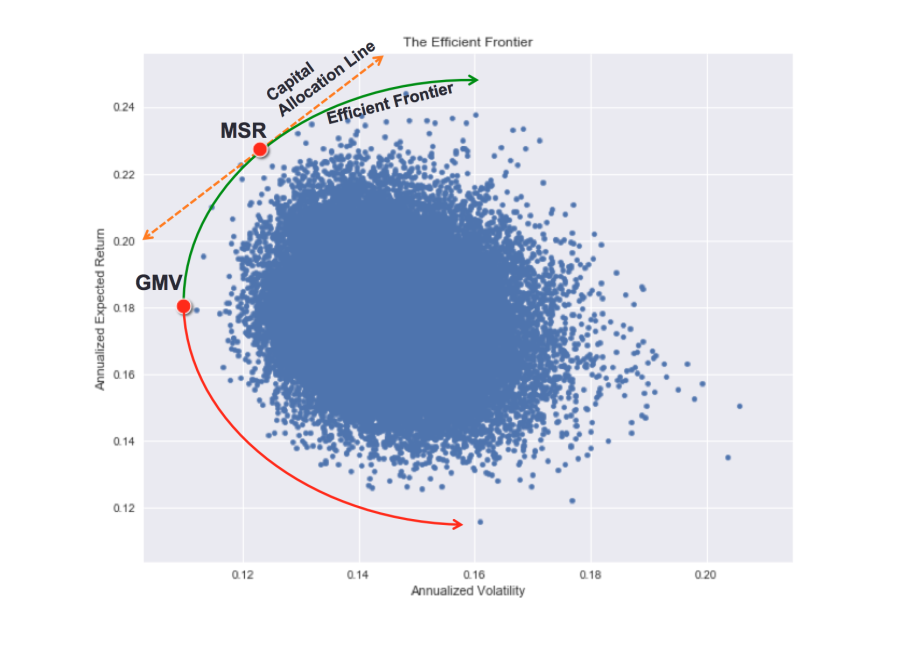

In [43]:
Image(filename="EF.png")

#### MSR portfolios
- stock weight is the maximum value of Sharpe for a given stock

In [12]:
RandomPortfolios = pd.read_csv('EfficientFrontierPortfoliosSlim.csv')

In [13]:
# Risk free rate
risk_free = 0

# Calculate the Sharpe Ratio for each asset
RandomPortfolios['Sharpe'] = (RandomPortfolios['Returns']-risk_free)/ RandomPortfolios['Volatility']

# Print the range of Sharpe ratios
print(RandomPortfolios['Sharpe'].describe()[['min', 'max']])

min    0.742884
max    2.270462
Name: Sharpe, dtype: float64


In [14]:
# Sort the portfolios by Sharpe ratio
sorted_portfolios = RandomPortfolios.sort_values(by=['Sharpe'], ascending=False)

# Extract the corresponding weights
MSR_weights = sorted_portfolios.iloc[0, 0:numstocks]

# Cast the MSR weights as a numpy array
MSR_weights_array = np.array(MSR_weights)

# Calculate the MSR portfolio returns
StockReturns['Portfolio_MSR'] = StockReturns.iloc[:, 0:numstocks].mul(MSR_weights_array, axis=1).sum(axis=1)

#### GMV portfolios
- stock weight is the minimum value of Volatility for a given stock

In [15]:
# Sort the portfolios by volatility
sorted_portfolios = RandomPortfolios.sort_values(by=['Volatility'], ascending=True)

# Extract the corresponding weights
GMV_weights = sorted_portfolios.iloc[0, 0:numstocks]

# Cast the GMV weights as a numpy array
GMV_weights_array = np.array(GMV_weights)

# Calculate the GMV portfolio returns
StockReturns['Portfolio_GMV'] = StockReturns.iloc[:, 0:numstocks].mul(GMV_weights_array, axis=1).sum(axis=1)

## Cumulative Portfolior Returns

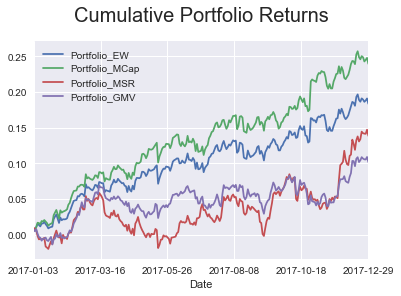

In [16]:
# Plot the cumulative portfolio returns over time
crew = ((1+StockReturns["Portfolio_EW"]).cumprod()-1)
crmcap = ((1+StockReturns["Portfolio_MCap"]).cumprod()-1)
crmsr = ((1+StockReturns["Portfolio_MSR"]).cumprod()-1)
crgmv = ((1+StockReturns["Portfolio_GMV"]).cumprod()-1)
crew.plot(label='Portfolio_EW')
crmcap.plot(label='Portfolio_MCap')
crmsr.plot(label="Portfolio_MSR")
crgmv.plot(label="Portfolio_GMV")
plt.title('Cumulative Portfolio Returns')
plt.legend()
plt.show()

## Portfolio standard deviation(portfolio volatility)
- $σ_{Portfolio}=\sqrt{w_T⋅Σ⋅w}$
- $σ_{Portfolio}$: portfolio volatility
- $Σ$: covariance matrix of returns
- $w$: portfolio weights ($w_T$ is transposed portfolio weights)
- $⋅$: the dot-multiplication operator

In [17]:
cov_mat_annual = StockReturns.iloc[:,:numstocks].cov()*252

portfolio_volatility = np.sqrt(np.dot(portfolio_weights_ew.T, np.dot(cov_mat_annual, portfolio_weights_ew)))
print(f"Portfolio_EW Annual Volatility: {portfolio_volatility:0.3f}")

portfolio_volatility = np.sqrt(np.dot(mcap_weights.T, np.dot(cov_mat_annual, mcap_weights)))
print(f"Portfolio_MCAP Annual Volatility: {portfolio_volatility:0.3f}")

portfolio_volatility = np.sqrt(np.dot(MSR_weights_array.T, np.dot(cov_mat_annual, MSR_weights_array)))
print(f"Portfolio_MSR Annual Volatility: {portfolio_volatility:0.3f}")

portfolio_volatility = np.sqrt(np.dot(GMV_weights_array.T, np.dot(cov_mat_annual, GMV_weights_array)))
print(f"Portfolio_GMV Annual Volatility: {portfolio_volatility:0.3f}")

Portfolio_EW Annual Volatility: 0.084
Portfolio_MCAP Annual Volatility: 0.090
Portfolio_MSR Annual Volatility: 0.107
Portfolio_GMV Annual Volatility: 0.087


# Factor Investing

In [18]:
FamaFrenchData = pd.read_csv('FamaFrenchFactors.csv')
FamaFrenchData['Date'] = pd.to_datetime(FamaFrenchData['Date'], format='%Y-%m-%d')
FamaFrenchData.set_index(['Date'],inplace=True)

##  Capital Asset Pricing Model
- $E(R_P)−RF=β_P(E(R_M)−RF)$ 
- $E(R_P)−RF$: the excess expected return of a stock or portfolio P
- $E(R_M)−RF$: the excess expected return of the broad market portfolio B
- $RF$: the regional risk free-rate
- $β_P$: portfolio beta, or exposure, to the broad market portfolio B

In [19]:
# Calculate excess portfolio returns
FamaFrenchData['Portfolio_Excess'] = FamaFrenchData['Portfolio']-FamaFrenchData['RF']

# Define the regression formula
CAPM_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess', data=FamaFrenchData)

#r-squared: percentage variance of the regressed variable explained by the fitted regression
CAPM_fit = CAPM_model.fit()
print(f"CAPM model r-squared: {CAPM_fit.rsquared_adj:0.3f}")

CAPM model r-squared: 0.794


C:\Users\Thinkpad\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Fama-French 3 Factor Model
- $R_P=RF+β_M(R_M−RF)+b_{SMB}.SMB+b_{HML}.HML+α$ 
- $SMB$: small minus big factor (small stocks tend to out-perform big stocks)
- $b_SMB$: exposure to SMB factor
- $HML$: high minus low factor (value versus growth, more ciclical)
- $b_HML$: exposure to HML
- $α$: perfomance unexplained by other factors
- small + value stocks tend to be the best (as oposed to large + growth stocks)

### Model

In [21]:
FamaFrench_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML', data=FamaFrenchData)
FamaFrench_fit = FamaFrench_model.fit()
regression_adj_rsq = FamaFrench_fit.rsquared_adj

print("Fama French model r-squared: {:0.3f}".format(regression_adj_rsq))

Fama French model r-squared: 0.819


### p-value and statistical significance

In [22]:
# Extract the p-value of the SMB factor
smb_pval = FamaFrench_fit.pvalues["SMB"]

if smb_pval < 0.05:
    significant_msg = 'significant'
else:
    significant_msg = 'not significant'

smb_coeff = FamaFrench_fit.params['SMB']
print(f"The SMB coefficient is {smb_coeff:0.3f} and is {significant_msg}")

The SMB coefficient is -0.262 and is significant


### unexplained return

In [23]:
portfolio_alpha = FamaFrench_fit.params["Intercept"]
portfolio_alpha_annualized = ((1+portfolio_alpha)**252)-1
print(f"Unxplained return: {portfolio_alpha_annualized:0.3f}")

Unxplained return: 0.047


## Fama-French 5 Factor Model
- RMW: returns of companies with high vs low operating profitability
- CMA: returns of companies with aggressive investments versus conservative.

In [24]:
form='Portfolio_Excess ~ Market_Excess + SMB + HML + RMW + CMA'
FamaFrench5_model = smf.ols(formula=form, data=FamaFrenchData)
FamaFrench5_fit = FamaFrench5_model.fit()
regression_adj_rsq = FamaFrench5_fit.rsquared_adj

print("5 factor model r-squared: {:0.3f}".format(regression_adj_rsq))

5 factor model r-squared: 0.837


# Risk Management

## Estimating Tail Risk
- **Value at Risk(VaR)**：a way to estimate the risk of a single day negative price movement
- **Conditional Value at Risk(CVaR) / Expected Shortfall**: the expected loss of the worst case scenarios of returns

In [25]:
risk = pd.read_csv('USO.csv')
risk['cum_rets'] = (1+risk['USO']).cumprod()-1
risk['Returns'] = risk['USO']
risk['Returns_perc'] = risk['USO']*100.

In [26]:
risk['Date'] = pd.to_datetime(risk['Date'], format='%Y-%m-%d')
risk.set_index(['Date'],inplace=True)

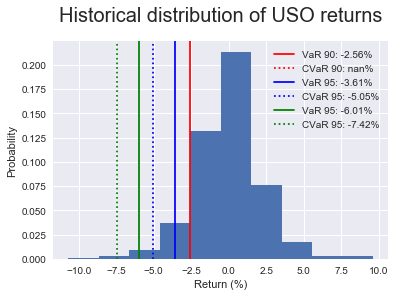

In [27]:
var_level = 90
var_90 = np.percentile(risk['Returns_perc'], 100-var_level)
cvar_90 = risk['Returns_perc'][risk['Returns'] <= var_90].mean()

var_level = 95
var_95 = np.percentile(risk['Returns_perc'], 100-var_level)
cvar_95 = risk['Returns_perc'][risk['Returns_perc'] <= var_95].mean()

var_level = 99
var_99 = np.percentile(risk['Returns_perc'], 100-var_level)
cvar_99 = risk['Returns_perc'][risk['Returns_perc'] <= var_99].mean()

# Sort the returns for plotting
sorted_rets = sorted(risk['Returns_perc'])

# Plot the probability of each return quantile
plt.hist(sorted_rets, density=True)

# Denote the VaR 95 and CVaR 95 quantiles
plt.axvline(x=var_90, color="r", linestyle="-", label='VaR 90: {0:.2f}%'.format(var_90))
plt.axvline(x=cvar_90, color='r', linestyle=':', label='CVaR 90: {0:.2f}%'.format(cvar_90))
plt.axvline(x=var_95, color="b", linestyle="-", label='VaR 95: {0:.2f}%'.format(var_95))
plt.axvline(x=cvar_95, color='b', linestyle=':', label='CVaR 95: {0:.2f}%'.format(cvar_95))
plt.axvline(x=var_99, color="g", linestyle="-", label='VaR 95: {0:.2f}%'.format(var_99))
plt.axvline(x=cvar_99, color='g', linestyle=':', label='CVaR 95: {0:.2f}%'.format(cvar_99))
plt.title('Historical distribution of USO returns')
plt.ylabel('Probability'), plt.xlabel('Return (%)')
plt.legend()
plt.show()

## Parametric VaR
- using probability distribution instead of discrete historical values

In [28]:
mu = np.mean(risk['Returns'])
vol = np.std(risk['Returns'])
confidence_level = 0.05

# Calculate Parametric VaR
var_95 = norm.ppf(confidence_level, mu, vol)
print(f"Mean: {mu:0.5f},\nVolatility: {vol:0.5f},\nVaR(95): {100*var_95:0.5f}")

Mean: -0.00029,
Volatility: 0.02189,
VaR(95): -3.62891


## Scaling Risk Estimates
- to estimate t-day $VaR(95)_{t days} =  VaR(95)_{1 day} * \sqrt{t}$
- the loss increases with time

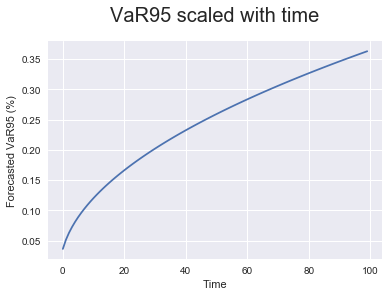

In [29]:
# se this data to estimate the VaR for the USO oil ETF for 1 to 100 days from now

# Aggregate forecasted VaR
forecasted_values = np.empty([100, 2])

# Loop through each forecast period
for i in range(0,100):
    # Save the time horizon i
    forecasted_values[i, 0] = i
    # Save the forecasted VaR 95
    forecasted_values[i, 1] = var_95*np.sqrt(i+1)
    
# Plot the results
plt.plot(forecasted_values[:, 0],-forecasted_values[:, 1])
plt.title('VaR95 scaled with time')
plt.xlabel('Time'), plt.ylabel('Forecasted VaR95 (%)')
plt.show()  

## Monte Carlo Simulation

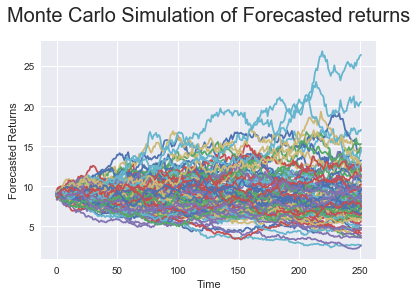

Parametric VaR(95): -3.61
Parametric VaR(99): -5.10


In [30]:
mu = np.mean(risk['Returns'])
vol = np.std(risk['Returns'])
T = 252 # period
S0 = 10 # initial stock value

np.random.seed(seed=1)
sim_returns = []

# Loop through 100 simulations
for i in range(0,100):
    rand_rets = np.random.normal(mu, vol, T)   
    forecasted_values = S0*(rand_rets+1).cumprod()-1
    sim_returns.append(rand_rets)
    
    # Plot the Monte Carlo path
    plt.plot(range(0,T), forecasted_values)

# Show the simulations
plt.title('Monte Carlo Simulation of Forecasted returns')
plt.xlabel('Time'), plt.ylabel('Forecasted Returns')
plt.show()

var_95 = np.percentile(sim_returns, 5)
var_99 = np.percentile(sim_returns, 1)
print(f"Parametric VaR(95): {100*var_95:0.2f}")
print(f"Parametric VaR(99): {100*var_99:0.2f}")